<a href="https://colab.research.google.com/github/euxoa/ompeluseura/blob/master/Ompeluseura_apt_get.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
start_time <- Sys.time()

In [0]:
# install.packages takes ages (20mins) in Colab so we will install dependencies apt-get
system("apt-get update")
system("apt install -y r-cran-readr")
system("apt install -y r-cran-dplyr")
system("apt install -y r-cran-rstan")
system("apt install -y r-cran-bayesplot")
print(Sys.time() - start_time)

Time difference of 10.50668 secs


In [0]:
options(repr.plot.width  = 8, repr.plot.height = 4)
Sys.setenv(USE_CXX14 = 1) # use C++14 compiler

library("rstan") # observe startup messages


Loading required package: StanHeaders
Loading required package: ggplot2
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


In [0]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)
library("bayesplot")

This is bayesplot version 1.7.0
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting


In [0]:
library("dplyr")
library("ggplot2")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [0]:
print(Sys.time() - start_time)

Time difference of 11.32833 secs


The data consists of average monthly temperatures from the FMI Kilpisjärvi station, for the last four decades. FMI has their own API, but casual downloads are easiest through their interactive service at https://ilmatieteenlaitos.fi/havaintojen-lataus#!/

Why Kilpisjärvi? Its a beautiful place, one of the few mountaineous areas in Finland. Its high latitude its temperature interesting, for warming due to greenhouse gases tends to be much more pronounced in the artic than on southern latitudes. The scripts on this notebook are general though, so that you can insert data from your favorite locations easily.

In [0]:
d <- readr::read_csv("https://raw.githubusercontent.com/euxoa/ompeluseura/master/kilpisjarvi_raw.csv") %>% 
  setNames(c("year", "month", "day", "_clock", "tzone", "temp")) %>%
  mutate(t = ISOdate(year, month, day), 
         f_month = as.factor(month),
         decade = as.numeric(t - ISOdate(2000, 1, 1), units="days")/365.25) %>%
  select(year, f_month, t, decade, temp)


Parsed with column specification:
cols(
  Vuosi = col_double(),
  Kk = col_double(),
  Pv = col_double(),
  Klo = col_time(format = ""),
  Aikavyöhyke = col_character(),
  `Kuukauden keskilämpötila (degC)` = col_double()
)


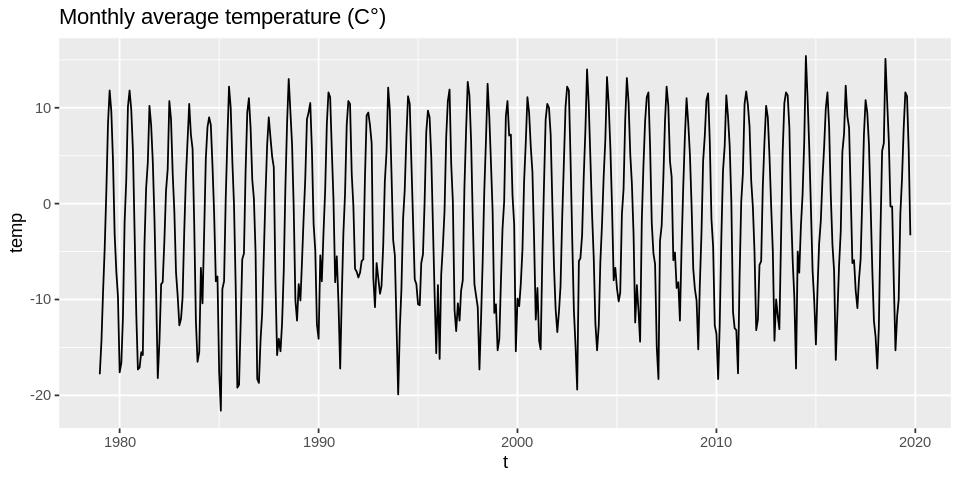

In [0]:
ggplot(d, aes(x=t, y=temp)) + geom_line() + labs(title = "Monthly average temperature (C°)")

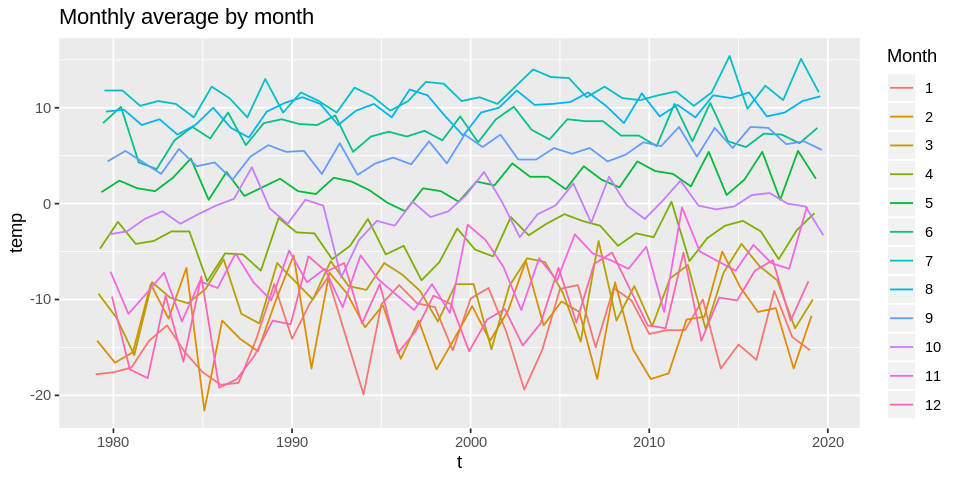

In [0]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_line() + labs(title = "Monthly average by month", color= "Month")

An upward trend is obvious. Note high variance of the winter months!

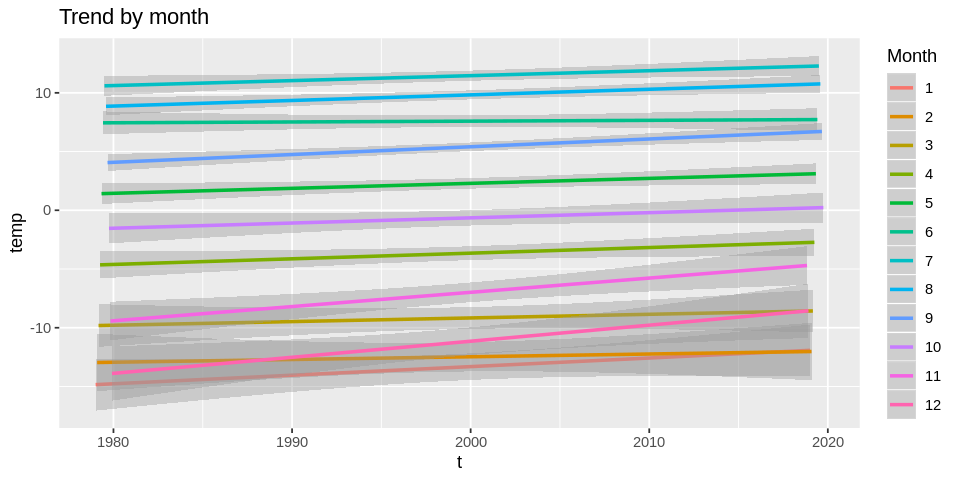

In [0]:
ggplot(d, aes(x=t, y=temp, color=f_month)) + geom_smooth(method="lm") + labs(title = "Trend by month", color= "Month")

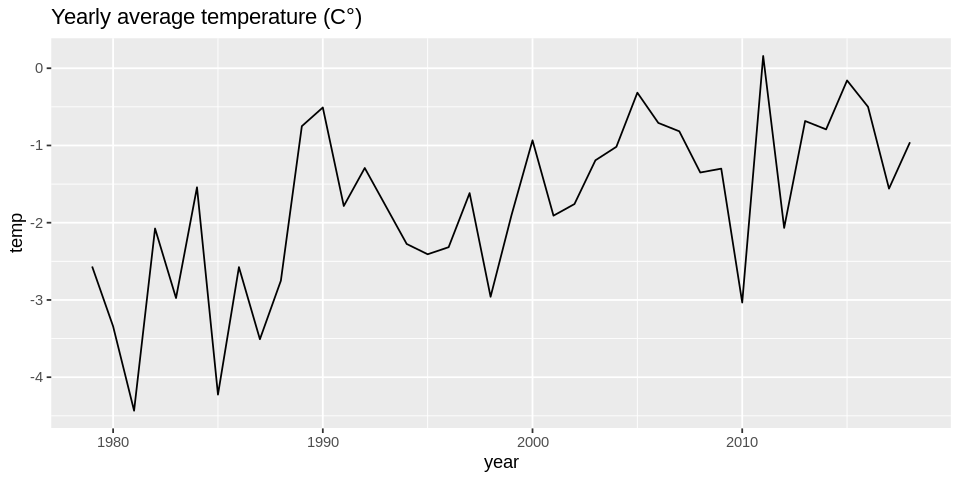

In [0]:
d_year <- d %>% group_by(year) %>% summarise(n=n(), temp=mean(temp), decade=mean(decade)) %>% filter(n==12)

ggplot(d_year, aes(x=year, y=temp)) + geom_line() + labs(title = "Yearly average temperature (C°)")

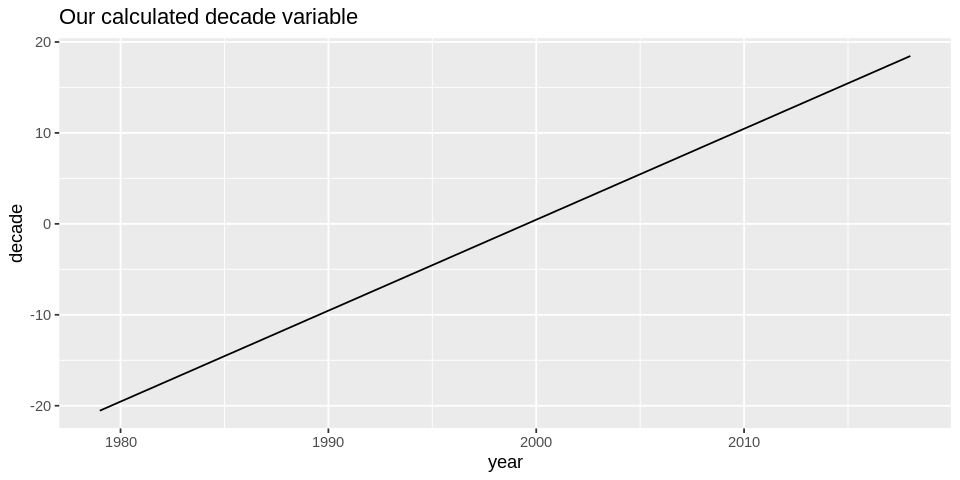

In [0]:
# Our calculated decade variable is just distance from 1.1.2000 in years. Almost normalized way of presenting year.
ggplot(d_year, aes(x=year, y=decade)) + geom_line() + labs(title = "Our calculated decade variable")

In [0]:
stan_data <- with(d_year, list(N=length(temp), decade=decade, temp=temp))

In [0]:
compile_and_fit_model <- function(model_code, data, vars_of_interest) {
  stan_start_time <- Sys.time()
  model <- stan_model(model_code = model_code) # compilation takes time if model is changed
  fit <- sampling(model, data = data)
  message("Compilation and fitting in secs ", difftime(Sys.time(), stan_start_time, units="secs"))
  
  posterior <- as.matrix(fit)
  print(traceplot(fit))
  print(fit)

  # Print posterior distributions for interesting variables
  posterior <- as.matrix(fit)
  for (var_name in vars_of_interest)
  {
    plot <- mcmc_areas(posterior, pars = c(var_name), prob = 0.8)  + 
      ggtitle(paste("Variable ", var_name, " posterior distributions with median and 80% interval"))
    print(plot)  
  }

  message("Total duration in secs ", difftime(Sys.time(), stan_start_time, units="secs"))
  return(fit)
}

Compilation and fitting in secs 72.4962105751038


Inference for Stan model: 1ba1786ebbac82d7206777eaaf7e168e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
a      -1.70    0.00 0.14  -1.98  -1.80  -1.71  -1.61  -1.42  3071    1
b       0.06    0.00 0.01   0.04   0.05   0.06   0.07   0.08  3654    1
sigma   0.89    0.00 0.11   0.71   0.82   0.88   0.96   1.14  2943    1
lp__  -14.49    0.03 1.26 -17.69 -15.04 -14.17 -13.58 -13.05  1860    1

Samples were drawn using NUTS(diag_e) at Thu Dec  5 10:38:57 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Total duration in secs 73.7528183460236


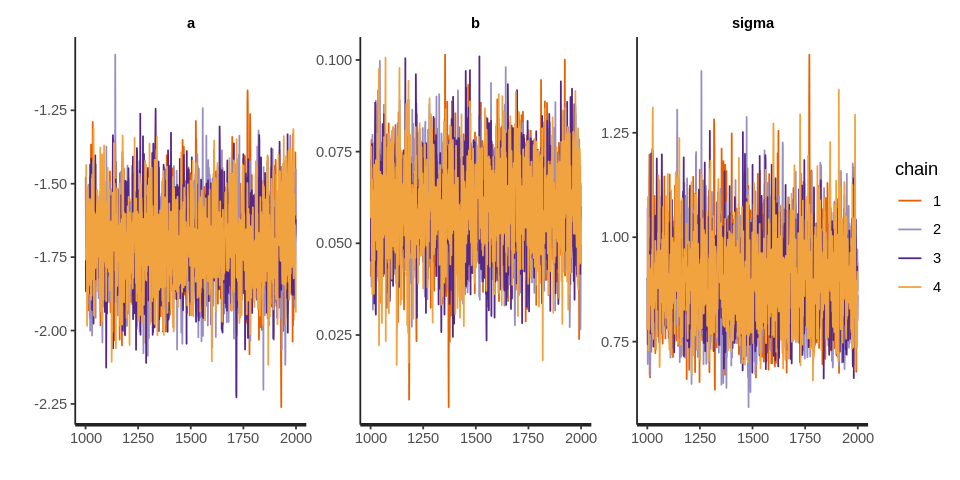

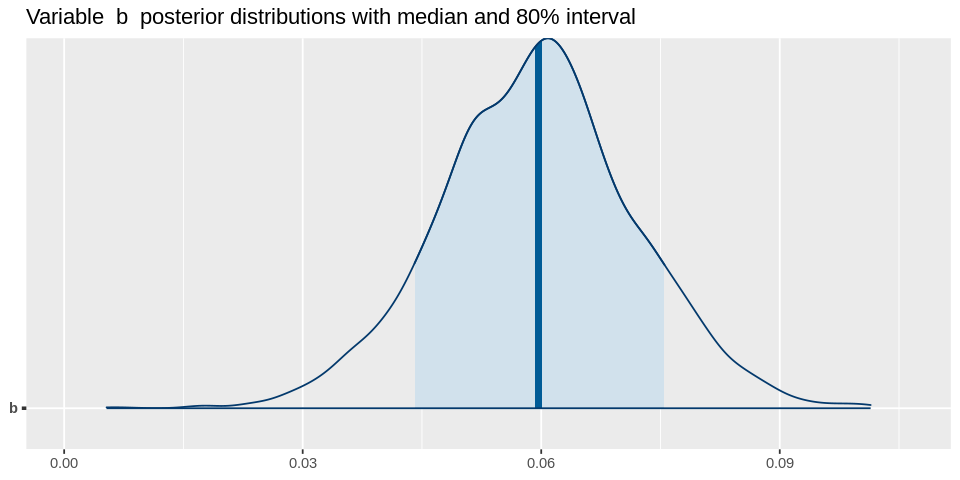

In [0]:
model_simple_normal <- "
data {
  int<lower=0> N;
  vector[N] decade;
  vector[N] temp;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  temp ~ normal(a + b * decade, sigma);
}
"
fit_sn <- compile_and_fit_model(model_code = model_simple_normal, data = stan_data, vars_of_interest = c("b"))


In [0]:

monthly_model_code <- "
data {
  int N;
  real decade[N];
  real temp[N];
  int month[N];
}
parameters {
  real<lower=0> sigma[12];
  real b[12];
  real k[12];
}
model {
  for (i in 1:N) {
     int m = month[i];
     temp[i] ~ normal(k[m] * decade[i] + b[m], sigma[m]); }
  sigma ~ normal(0, 5);
  b ~ normal(0, 5);
  k ~ normal(0, 1);
}
"
fit <- compile_and_fit_model(model_code = monthly_model_code, data = stan_data, vars_of_interest = c())

recompiling to avoid crashing R session


Error in new_CppObject_xp(fields$.module, fields$.pointer, ...) : 
  Exception: variable does not exist; processing stage=data initialization; variable name=month; base type=int  (in 'model9f35919469f_9a2d1e14cab629b91a257d84eadcb8b4' at line 6)



failed to create the sampler; sampling not done
Compilation and fitting in secs 69.8883445262909


Stan model '9a2d1e14cab629b91a257d84eadcb8b4' does not contain samples.
NULL
Stan model '9a2d1e14cab629b91a257d84eadcb8b4' does not contain samples.


Total duration in secs 69.8930108547211
